### GP CARMA Fitting Test

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 07-17-20
<br>**Short description:** This notebook will test the fitting accuracy of the GP method. LC simulation will be carried out by `celerite` as well.

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

In [2]:
# import GP modules
from agntk.carma.CARMATerm import *
from celerite import GP
import dask
from scipy.optimize import minimize

### 1. Simulata LC in chunk
In this section, we will simulate a collection of DRW light curves using a grid placed in the parameter space of $\tau$ and the standard deviate ($\sigma_{DRW}^{2} = \frac{\tau\sigma^{2}}{2}$) of the simulated light curves. We will uniformly draw parameters from 10 days < $\tau$ < 365 days and 0.05 mag < $\sigma_{DRW}$ < 0.35 mag. The simulated light curves will have a 1 day cadence and 10 years baseline.

In [3]:
# define log posterior function
def neg_log_prob(params, y, yerr, gp):
    gp.set_parameter_vector(params)
    amp = gp.kernel.get_rms_amp()
    model_std = np.sqrt(np.var(y) - np.var(yerr))
    
    # below add a prior using the estimated model std from light curve
    return -gp.log_likelihood(y) + 100*(amp - model_std)**2/2

In [4]:
def downsample_byN(t, nObs):
    """Utility function to randomly choose N observation from a given light curves
    
    Args:
        t(array_like): Time stamp of observations in the original light curve.
        N(int): The number of observations in the final light curve.

    Returns:
        An mask of the original length to select data point.
    """
    
    # random choose index
    idx = np.arange(len(t))
    mask = np.zeros_like(idx, dtype=np.bool)
    true_idx = np.random.choice(idx, nObs, replace=False)
    
    # assign chosen index to 1/True
    mask[true_idx] = 1
    
    return mask

In [5]:
# funtion to parallel LC simulation and fitting with Dask
@dask.delayed
def simLC_fit(tauErrArr, ampErrArr, tau, amp, row, col, N=100, duration=3650.0, errAmp=0.0):

    try:
        kernel = DRW_term(np.log(amp), np.log(tau))
        gp_sim = GP(kernel)
        
        # first init 10K time stamps and random draw 100
        t = np.linspace(0, duration, 10000)
        mask = downsample_byN(t, N) # randomly select N time stamps
        t = t[mask] 
        yerr = np.random.normal(0, 1e-7, N) # give very tiny error
        gp_sim.compute(t, yerr)
        
        tauErr = []
        ampErr = []
        
        # for each param combo, simulate 100 light curves
        for i in range(50):
           
            # simulate LC
            y = gp_sim.sample()

            while np.abs((np.std(y)-amp)/amp) > 0.05:
                y = gp_sim.sample()

            if (errAmp != 0.0) & (errAmp > 0):
                yerr = np.random.normal(0, errAmp, N) # if err provided, replace
                y += yerr


            ## start fitting
            # initialize parameter in the possible range
            init_tau = np.exp(np.random.uniform(1, np.log(1000), 1)[0])
            init_amp = np.random.uniform(0, 0.35, 1)[0]

            kernel_fit = DRW_term(np.log(init_amp), np.log(init_tau))
            gp_fit = GP(kernel_fit)
            gp_fit.compute(t, yerr)

            initial_params = gp_fit.get_parameter_vector()
            bounds = gp_fit.get_parameter_bounds()

            r = minimize(neg_log_prob, initial_params, method="L-BFGS-B", bounds=bounds, \
                         args=(y, yerr, gp_fit))
            
            # compute pecentage err for each LC and add to list
            input_param = np.array([amp, tau])
            err = (np.exp(r.x) - input_param)/input_param
            ampErr.append(err[0])
            tauErr.append(err[1])
            
        # assign result of result array
        ampErrArr[row, col, :] = ampErr
        tauErrArr[row, col, :] = tauErr
    
    except Exception as e:
        print(e)
        print(f'Failed at ({row}, {col})!')
        return 1
    
    return 0

In [6]:
# construct grid in param space
dim = 20
amp = np.linspace(0.05, 0.35, dim)
tau = np.logspace(np.log10(10), np.log10(1000), dim)

# construct arr to store lc
ampErrArr = np.empty((dim,dim,50))
tauErrArr = np.empty((dim,dim,50))

In [7]:
#simLC/fit
all_result = []
for tau_i in range(dim):
    for amp_i in range(dim):
        tau_val = tau[tau_i]
        amp_val = amp[amp_i]
        all_result.append(simLC_fit(tauErrArr, ampErrArr, tau_val, amp_val, tau_i, amp_i))
total = dask.delayed(sum)(all_result)
sum_num = total.compute()
print(sum_num)

/home/conda/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/mount/agntk/src/agntk/carma/CARMATerm.py:61: RuntimeWarning: overflow encountered in exp
  return (np.exp(2 * log_sigma), 1 / np.exp(log_tau))


failed to factorize or solve matrix
Failed at (17, 10)!
failed to factorize or solve matrix
Failed at (19, 16)!
2


Let's look at a few parameter configurations and how good we can recover them. 

In [36]:
# convert to pecrcentage
tauErrArr = tauErrArr*100
ampErrArr = ampErrArr*100

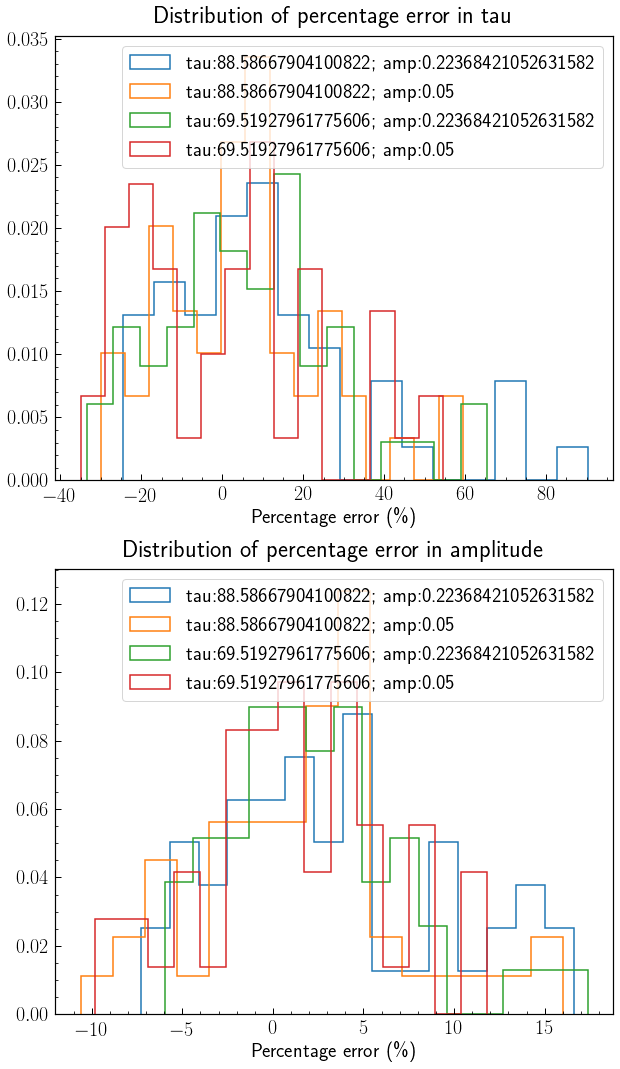

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(10, 18))
rows = np.random.choice(np.arange(20), 2)
cols = np.random.choice(np.arange(20), 2)

for row_idx in rows:
    for col_idx in cols:
        axs[0].hist(tauErrArr[row_idx, col_idx, :].flatten(), histtype='step', \
                    label='tau:{}; amp:{}'.format(tau[row_idx], amp[col_idx]), \
                    density=True, bins=15, linewidth=1.5)
        axs[0].set_title('Distribution of percentage error in tau')
        axs[0].set_xlabel('Percentage error (\%)')
        axs[0].legend()
        
        axs[1].hist(ampErrArr[row_idx, col_idx, :].flatten(), histtype='step', \
                    label='tau:{}; amp:{}'.format(tau[row_idx], amp[col_idx]), \
                    density=True, bins=15, linewidth=1.5)
        axs[1].set_title('Distribution of percentage error in amplitude')
        axs[1].set_xlabel('Percentage error (\%)')
        axs[1].legend()

plt.subplots_adjust(hspace=0.2)

<span style='color:red'> It should be sufficient to use mean and standad deviation to quanlity how well we can recover the parameters. Next, let's compute these two summary statistics on all parameter configurations and plot it on a grid.</span>

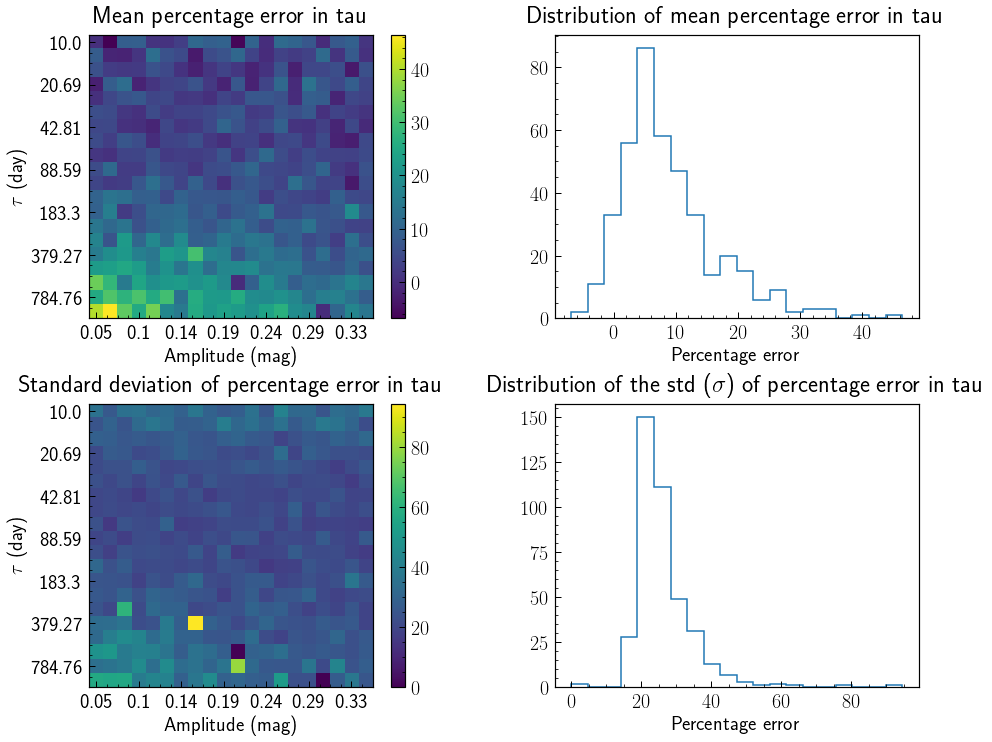

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(15,12))
tick_scale = 3

# grid plot for tau
mean_tau_err = np.mean(tauErrArr, axis=2)
im1 = axs[0,0].imshow(mean_tau_err)
fig.colorbar(im1, ax=axs[0,0])

_ = axs[0,0].set_xticks(np.arange(dim)[::tick_scale])
_ = axs[0,0].set_xticklabels(np.around(amp, 2)[::tick_scale])
_ = axs[0,0].set_yticks(np.arange(dim)[::tick_scale])
_ = axs[0,0].set_yticklabels(np.around(tau, 2)[::tick_scale])

# distribution for tau
axs[0,0].set_title('Mean percentage error in tau')
axs[0,0].set_xlabel('Amplitude (mag)')
axs[0,0].set_ylabel('$\\tau$ (day)')

_ = axs[0,1].hist(mean_tau_err.flatten(), bins=20, histtype='step', linewidth=1.5)
axs[0,1].set_title('Distribution of mean percentage error in tau')
axs[0,1].set_xlabel('Percentage error ')

# grid plot for amplitude
std_tau_err = np.std(tauErrArr, axis=2)
im2 = axs[1,0].imshow(std_tau_err)
fig.colorbar(im2, ax=axs[1,0])

_ = axs[1,0].set_xticks(np.arange(dim)[::tick_scale])
_ = axs[1,0].set_xticklabels(np.around(amp, 2)[::tick_scale])
_ = axs[1,0].set_yticks(np.arange(dim)[::tick_scale])
_ = axs[1,0].set_yticklabels(np.around(tau, 2)[::tick_scale])

# distribution for amplitude
axs[1,0].set_title('Standard deviation of percentage error in tau')
axs[1,0].set_xlabel('Amplitude (mag)')
axs[1,0].set_ylabel('$\\tau$ (day)')

_ = axs[1,1].hist(std_tau_err.flatten(), bins=20, histtype='step', linewidth=1.5)
axs[1,1].set_title('Distribution of the std ($\sigma$) of percentage error in tau')
axs[1,1].set_xlabel('Percentage error ')

plt.subplots_adjust(hspace=0.3, wspace=0.3)

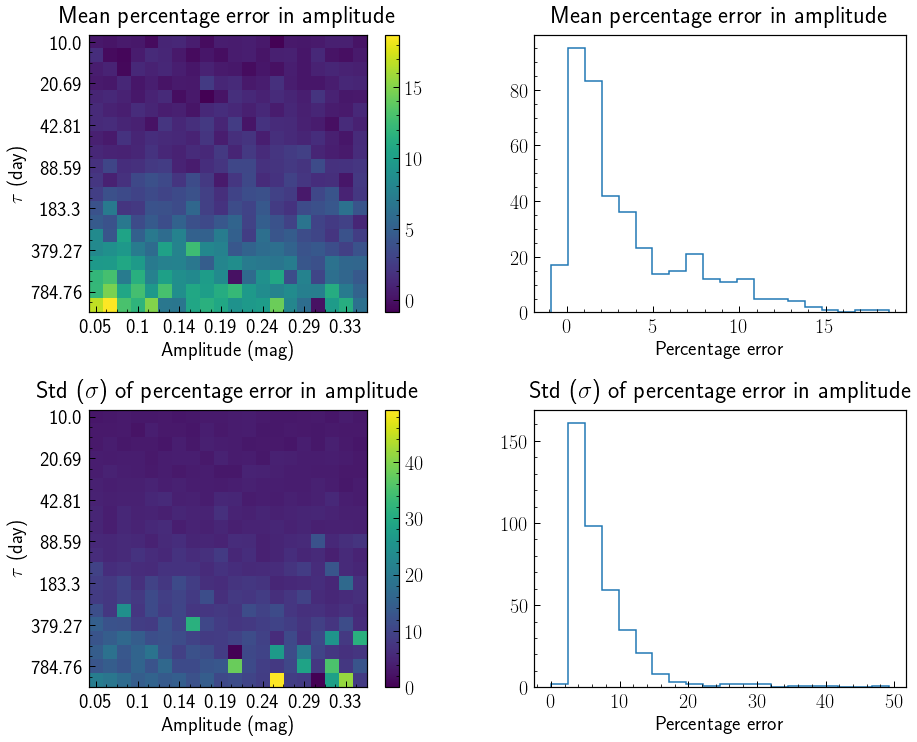

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(15,12))
tick_scale = 3

# grid plot for tau
mean_amp_err = np.mean(ampErrArr, axis=2)
im3 = axs[0,0].imshow(mean_amp_err)
fig.colorbar(im3, ax=axs[0,0])

_ = axs[0,0].set_xticks(np.arange(dim)[::tick_scale])
_ = axs[0,0].set_xticklabels(np.around(amp, 2)[::tick_scale])
_ = axs[0,0].set_yticks(np.arange(dim)[::tick_scale])
_ = axs[0,0].set_yticklabels(np.around(tau, 2)[::tick_scale])

# distribution for tau
axs[0,0].set_title('Mean percentage error in amplitude')
axs[0,0].set_xlabel('Amplitude (mag)')
axs[0,0].set_ylabel('$\\tau$ (day)')

_ = axs[0,1].hist(mean_amp_err.flatten(), bins=20, histtype='step', linewidth=1.5)
axs[0,1].set_title('Mean percentage error in amplitude')
axs[0,1].set_xlabel('Percentage error ')

# grid plot for amplitude
std_amp_err = np.std(ampErrArr, axis=2)
im4 = axs[1,0].imshow(std_amp_err)
fig.colorbar(im4, ax=axs[1,0])

_ = axs[1,0].set_xticks(np.arange(dim)[::tick_scale])
_ = axs[1,0].set_xticklabels(np.around(amp, 2)[::tick_scale])
_ = axs[1,0].set_yticks(np.arange(dim)[::tick_scale])
_ = axs[1,0].set_yticklabels(np.around(tau, 2)[::tick_scale])

# distribution for amplitude
axs[1,0].set_title('Std ($\sigma$) of percentage error in amplitude')
axs[1,0].set_xlabel('Amplitude (mag)')
axs[1,0].set_ylabel('$\\tau$ (day)')

_ = axs[1,1].hist(std_amp_err.flatten(), bins=20, histtype='step', linewidth=1.5)
axs[1,1].set_title('Std ($\sigma$) of percentage error in amplitude')
axs[1,1].set_xlabel('Percentage error ')

plt.subplots_adjust(hspace=0.35, wspace=0.25)